In [106]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

Acquired zillow data using acquire.py (sequel query in this file)

In [107]:
# df = acquire.get_zillow_data()
# df.head()

In [108]:
df = pd.read_csv("zillow_dataframe.csv")

In [109]:
df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

In [110]:
df.shape

(52169, 15)

In [111]:
# df = prepare.handle_missing_values(df)

In [112]:
df.isnull().sum()

tax_rate                            5
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet        8
fips                                0
garagecarcnt                    34203
latitude                            0
longitude                           0
lotsizesquarefeet                 354
poolcnt                         41105
taxvaluedollarcnt                   1
yearbuilt                          40
landtaxvaluedollarcnt               1
logerror                            0
county_name                         0
dtype: int64

### Add new features for modeling:
- Scale latitude and longitude by hand
- price_per_sq_ft (value of house / house square footage
- land_price_per_sq_ft  (land tax value / lot square footage)

In [113]:
df.latitude = df.latitude / 1_000_000 
df.longitude = df.longitude / 1_000_000 

In [114]:
df['price_per_sq_ft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
df['lot_price_per_sq_ft'] = df['landtaxvaluedollarcnt'] / df['lotsizesquarefeet']

In [116]:
df.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft
0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,33.63,-117.87,"4,506.00",nan,"1,023,282.00","1,998.00","537,569.00",0.03,Orange,330.09,119.30
1,0.01,1.00,2.00,"1,465.00","6,111.00",1.00,34.45,-119.28,"12,647.00",nan,"464,000.00","1,967.00","376,000.00",0.06,Ventura,316.72,29.73
2,0.01,2.00,3.00,"1,243.00","6,059.00",2.00,33.89,-117.82,"8,432.00",1.00,"564,778.00","1,962.00","479,489.00",0.01,Orange,454.37,56.87
3,0.01,3.00,4.00,"2,376.00","6,037.00",nan,34.25,-118.24,"13,038.00",1.00,"145,143.00","1,970.00","36,225.00",-0.10,Los Angeles,61.09,2.78
4,0.01,3.00,4.00,"2,962.00","6,037.00",nan,34.15,-118.18,"63,000.00",1.00,"773,303.00","1,950.00","496,619.00",-0.00,Los Angeles,261.07,7.88


****** move this drop columns code to after the exploration phase ******

In [47]:
# df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

### Split the data into train and test, 70/30

In [48]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [49]:
train.shape

(36518, 17)

In [50]:
test.shape

(15651, 17)

### Proof of Concept - Clustering fips (aka binning the 3 different counties)

In [15]:
# def create_k_clusters(train, test, cluster_feature_id, cluster_cols, k):
#     kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
#     kmeans.fit(train[[cluster_cols]])
#     cluster_feature = 'cluster'+str(cluster_feature_id)+'_id'
#     train[cluster_feature] = kmeans.predict(train[[cluster_cols]])
#     test[cluster_feature] = kmeans.predict(test[[cluster_cols]])
#     return train, test, kmeans

In [16]:
# train, test, kmeans1 = create_k_clusters(train, test, cluster_feature_id = 1, cluster_cols = 'fips', k=3)

In [17]:
# train, test, kmeans = fips_cluster(train, test, columns='fips', n=3)

In [18]:
kmeans = KMeans(n_clusters=3, n_init=1, max_iter=100, random_state=123)

In [51]:
kmeans.fit(train[['fips']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [52]:
cluster = 'cluster_' + str('fips')

train[cluster] = kmeans.predict(train[['fips']])

test[cluster] = kmeans.predict(test[['fips']])

In [53]:
# X1 = train[['fips']]
# X2 = test[['fips']]

In [22]:
# X1 = train[['fips']]
# X2 = test[['fips']]

# kmeans = KMeans(n_clusters=3, random_state=123, n_init=1, max_iter=100)
# kmeans.fit(X1)

# train['cluster'] = pd.Series(kmeans.predict(X1)).astype(str)
# test['cluster'] = pd.Series(kmeans.predict(X2)).astype(str)
                                         
# PREDICT ON X_train and predict on X_test for other clustering

In [23]:
# train['cluster'] = pd.Series(kmeans.predict(X1)).astype(str)

In [ ]:
# test['cluster'] = pd.Series(kmeans.predict(X2)).astype(str)

In [ ]:
# train_cluster_fips.isnull().sum()

In [ ]:
# train['cluster'] = pd.Series(kmeans.predict(X1)).astype(str)
# test['cluster'] = pd.Series(kmeans.predict(X2)).astype(str)

In [ ]:
# train_cluster_fips.isnull().sum()

Elbow method to determine how many clusters are necessary

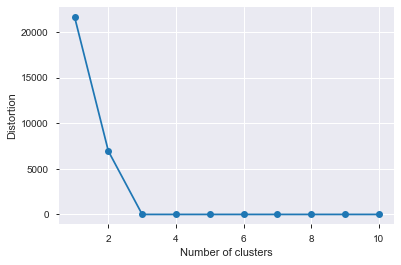

In [55]:
X1 = train[['cluster_fips']]
# calculate distortion for a range of numbers of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X1)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
# KMeans.predict?

## Clustering based on price per square foot, latitude, and longitude

In [56]:
kmeans = KMeans(n_clusters=10, n_init=1, max_iter=100, random_state=123)

In [61]:
train = train[pd.notnull(train['price_per_sq_ft'])]

In [59]:
test = test[pd.notnull(test['price_per_sq_ft'])]

In [64]:
train.price_per_sq_ft.isnull().sum()

0

In [63]:
test.price_per_sq_ft.isnull().sum()

0

In [66]:
kmeans.fit(train[['price_per_sq_ft', 'latitude', 'longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [67]:
cluster = 'cluster_' + str('sqft')

train[cluster] = kmeans.predict(train[['price_per_sq_ft', 'latitude', 'longitude']])

test[cluster] = kmeans.predict(test[['price_per_sq_ft', 'latitude', 'longitude']])

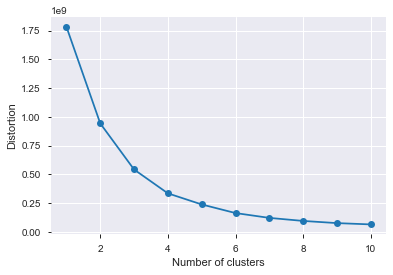

In [68]:
X2 = train[['price_per_sq_ft', 'latitude', 'longitude']]
# calculate distortion for a range of numbers of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X2)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Encode clusters

In [69]:
train_cluster_fips = train.drop(columns='cluster_sqft')
test_cluster_fips = test.drop(columns='cluster_sqft')

In [70]:
train_cluster_sqft = train.drop(columns='cluster_fips')
test_cluster_sqft = test.drop(columns='cluster_fips')

In [72]:
train_cluster_fips, test_cluster_fips, ohe1 = prepare.encode(train_cluster_fips, test_cluster_fips, 'cluster_fips')

In [74]:
train_cluster_sqft, test_cluster_sqft, ohe2 = prepare.encode(train_cluster_sqft, test_cluster_sqft, 'cluster_sqft')

### Inverse transform clusters to prove which county belongs to which cluster

In [ ]:
# ohe1.inverse_transform(df[['0', '1', '2']])

### Drop cluster column and rename clusters as county names

In [76]:
train_cluster_fips = train_cluster_fips.drop(columns='cluster_fips')

train_cluster_fips['los_angeles'] = train_cluster_fips['cluster_fips_0']
train_cluster_fips['ventura'] = train_cluster_fips['cluster_fips_1']
train_cluster_fips['orange'] = train_cluster_fips['cluster_fips_2']

train_cluster_fips = train_cluster_fips.drop(columns=['cluster_fips_0', 'cluster_fips_1', 'cluster_fips_2'])

KeyError: 'cluster_fips_0'

In [77]:
test_cluster_fips = test_cluster_fips.drop(columns='cluster_fips')

test_cluster_fips['los_angeles'] = test_cluster_fips['cluster_fips_0']
test_cluster_fips['ventura'] = test_cluster_fips['cluster_fips_1']
test_cluster_fips['orange'] = test_cluster_fips['cluster_fips_2']

test_cluster_fips = test_cluster_fips.drop(columns=['cluster_fips_0', 'cluster_fips_1', 'cluster_fips_2'])

KeyError: 'cluster_fips_0'

In [78]:
train.shape

(36515, 19)

In [79]:
test.shape

(15645, 19)

### Impute "poolcnt", "garagecarcnt" with 0s using a function. (reference prepare.py)

 - Run this on train and test subsets separately

In [80]:
cols = ["poolcnt", "garagecarcnt"]

In [81]:
train_cluster_sqft.price_per_sq_ft.head()

22620                 118.34
35532                  48.30
17905                 319.16
49147                 225.25
43935                 320.93
Name: price_per_sq_ft, dtype: float64

In [82]:
# Impute zeros into poolcnt and garagecarcnt on train set

train_cluster_sqft = prepare.fill_zero(train_cluster_sqft, cols=cols)

In [83]:
# Impute zeros into poolcnt and garagecarcnt on test set

test_cluster_sqft = prepare.fill_zero(test_cluster_sqft, cols=cols)

In [84]:
train_cluster_sqft.price_per_sq_ft.head()

22620                 118.34
35532                  48.30
17905                 319.16
49147                 225.25
43935                 320.93
Name: price_per_sq_ft, dtype: float64

### Drop columns then rows using function (reference prepare.py)

 - Run this on train and test subsets separately

In [85]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

train_cluster_sqft = prepare.handle_missing_values(train_cluster_sqft)

In [86]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

test_cluster_sqft = prepare.handle_missing_values(test_cluster_sqft)

In [87]:
train_cluster_sqft.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


### Drop the remaining Nulls in df to get clean train and test data sets

In [88]:
train_cluster_sqft.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [89]:
train_cluster_sqft.dropna(inplace=True)

In [90]:
test_cluster_sqft.dropna(inplace=True)

In [91]:
train_cluster_sqft.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


### The train and test subsets with no missing values and poolcnt and garagecarcnt imputed with zeros. Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with outliers handled, see below...

In [ ]:
train_cluster_sqft.isnull().sum()

In [ ]:
test_cluster_sqft.isnull().sum()

In [ ]:
train.bedroomcnt.value_counts()

In [ ]:
train.bathroomcnt.value_counts()

Zillow's log error was low on the los angeles high priced outlier.  LA county houses seems to have the highest log error outliers

In [ ]:
sns.scatterplot(data=train, x="logerror", y="price_per_sq_ft", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

Before outliers

In [ ]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

In [ ]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [ ]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
train.shape

In [ ]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
test.shape

### Convert dtypes to category for the cols below

- train_cat and test_cat are subsets with dtypes converted to category for the following columns:

    - "bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"
    
- train_cat and test_cat also have outliers handled and no missing values.

In [ ]:
train.info()

In [ ]:
cols = ["bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"]

In [ ]:
train_cat = prepare.numeric_to_category(train, cols)

In [ ]:
test_cat = prepare.numeric_to_category(test, cols)

In [ ]:
train_cat.info()

In [ ]:
train.bedroomcnt.value_counts()

In [ ]:
train.bathroomcnt.value_counts()

In [ ]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

In [ ]:
sns.scatterplot(data=train, x="logerror", y="price_per_sq_ft", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

In [ ]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

In [ ]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

## Bin yearbuilt by Decade

- 1878 - 2015

- Drop 11 rows with yearbuilt == 0.00

In [ ]:
sns.scatterplot(data=train_cat, x="yearbuilt", y="price_per_sq_ft")

In [ ]:
sns.scatterplot(data=train_cat, x="price_per_sq_ft", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="yearbuilt", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="lot_price_per_sq_ft", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="latitude", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="longitude", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="garagecarcnt", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="bedroomcnt", y="logerror")

### Stats Testing to Decide on Feature Engineering

- Here I use a chi2 test to look at categorical features.

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

In [ ]:
# contingency_table from the df_cat dataframe (w/o categories)

contingency_table = pd.crosstab(train_cat.bedroomcnt, train_cat.bathroomcnt)
contingency_table

In [ ]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [ ]:
print(f"The p-value of the contingency test is {p}.")

### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, I will combine the two features into a single feature that is a ratio of bedrooms to bathrooms.

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [ ]:
contingency_table = pd.crosstab(train_cat.garagecarcnt, train_cat.poolcnt)
contingency_table

In [ ]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [ ]:
print(f"The p-value of the contingency test is {p}.")

In [ ]:
r, p = stats.pearsonr(train_cat.lotsizesquarefeet, train_cat.taxvaluedollarcnt)

In [ ]:
print(f"r is {r}")

In [ ]:
print(f"p is {p}")

In [ ]:
# creating df handling values above 10_000 sqfeet to get a better look at the relationship between the variables

lot_no_outliers = train_cat[train_cat.lotsizesquarefeet > 10000]

### DB Scan this thingy

In [ ]:
sns.jointplot(data=lot_no_outliers, y="taxvaluedollarcnt", x="lotsizesquarefeet")

## Split train and test into X_train, X_test, y_train, y_test

In [ ]:
train_cluster_fips.head()

### Individually select every cluster and each feature to run through random tree regressor

In [95]:
train_cluster_sqft = train_cluster_sqft.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

In [96]:
test_cluster_sqft = test_cluster_sqft.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

In [97]:
train_cluster_sqft = train_cluster_sqft.drop(columns='county_name')
test_cluster_sqft = test_cluster_sqft.drop(columns='county_name')

In [98]:
X_train = train_cluster_sqft.drop(columns="logerror")

y_train = train_cluster_sqft[["logerror"]]

X_test = test_cluster_sqft.drop(columns="logerror")

y_test = test_cluster_sqft[["logerror"]]

## Model - Linear Regression Model

In [ ]:
X_train.dtypes

In [ ]:
X_train.head()

In [ ]:
X_train.garagecarcnt = X_train.garagecarcnt.astype(float)
X_train.bathroomcnt = X_train.bathroomcnt.astype(float)
X_train.bedroomcnt = X_train.bedroomcnt.astype(float)
X_train.poolcnt = X_train.poolcnt.astype(float)

In [ ]:
X_train = X_train.drop(columns='yearbuilt')
X_test = X_test.drop(columns='yearbuilt')

In [ ]:
# create the LR object

lm1 = LinearRegression()
print(lm1)

In [ ]:
# fit/train the model

model = lm1.fit(X_train, y_train)

In [ ]:
# create yhat variable, numpy array, in-sample prediction values

yhat = model.predict(X_train)
type(yhat)
yhat

In [ ]:
actual = y_train
actual.head()

In [ ]:
actual['yhat'] = yhat

### Evaluate LR Model

In [ ]:
actual["residual"] = actual["yhat"] - actual["logerror"]

In [ ]:
sns.distplot(actual["residual"])

In [ ]:
sns.scatterplot(actual["logerror"], actual["yhat"])

In [ ]:
actual["residual^2"] = actual["residual"] ** 2

In [ ]:
sse = sum(actual["residual^2"])
print(f"sse = {sse}")
mse = sse / len(actual)
print(f"mse = {mse}")
rmse = sqrt(mse)
print(f"rmse = {rmse}")

In [ ]:
df_eval = pd.DataFrame(np.array(["SSE", "MSE", "RMSE"]), columns=["metric"])
df_eval["model_error"] = np.array([sse, mse, rmse])
df_eval

- Create a numpy array from the y_df_nums_train df, so I can run eval metrics using yhat(prediction array) and y_array (array of actual y values)

In [ ]:
y_array = np.array(y_train)
type(y_array)

In [ ]:
r2_score(actual.logerror, actual.yhat)

In [ ]:
mse_lm1 = mean_squared_error(actual.logerror, actual.yhat)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(actual.logerror, actual.yhat)
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2_lm1))

### Takeaways from the Linear Regression Model:

- Based on the results above I fail to reject the Null Hypothesis that the numeric values alone can predict the logerror.

- Using a Linear Regression model to predict the logerror may not be the best choice.

- Finding a way to include categorical variables in a model may help predict logerror.

### Model - K Neighbors Regressor

In [ ]:
# create the object
neigh = KNeighborsRegressor(n_neighbors=2)

In [ ]:
# fit/train the model using train 
neigh.fit(X_train, y_train)

In [ ]:
yhat = neigh.predict(X_train)
type(yhat)

In [ ]:
r2 = neigh.score(X_train, y_train)

In [ ]:
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2))

### Takeaways from KNRegressor Model

- This model explained more than 50% more of the variance in logerror than my LR model using exactly the same data.

- The subset of data I used was comprised of the numeric values only from the original dataframe.

- I think this model could do even better with outliers handled and some feature engineering.

### Model df - Random Forest

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [100]:
rf = RandomForestRegressor(n_estimators=10)

In [101]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [102]:
X_train.head()

,tax_rate,bathroomcnt,bedroomcnt,fips,garagecarcnt,latitude,longitude,poolcnt,yearbuilt,price_per_sq_ft,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
22620,0.01,2.00,2.00,"6,059.00",2.00,33.85,-118.02,0.00,"1,955.00",118.34,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35532,0.02,2.00,3.00,"6,037.00",0.00,34.05,-118.08,0.00,"1,957.00",48.30,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
17905,0.01,3.00,4.00,"6,059.00",2.00,33.49,-117.64,1.00,"1,998.00",319.16,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
49147,0.01,3.00,4.00,"6,037.00",0.00,34.45,-118.57,0.00,"2,003.00",225.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
43935,0.01,3.00,4.00,"6,037.00",0.00,34.16,-118.41,1.00,"1,974.00",320.93,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [103]:
X_test.head()

,tax_rate,bathroomcnt,bedroomcnt,fips,garagecarcnt,latitude,longitude,poolcnt,yearbuilt,price_per_sq_ft,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
10408,0.03,2.00,3.00,"6,037.00",0.00,34.58,-118.06,0.00,"1,956.00",61.34,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
38980,0.01,3.00,5.00,"6,037.00",0.00,34.17,-118.45,0.00,"1,947.00",281.88,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
34986,0.01,2.50,3.00,"6,059.00",2.00,33.62,-117.65,1.00,"1,975.00",140.42,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
28445,0.01,2.50,4.00,"6,059.00",2.00,33.53,-117.67,0.00,"2,000.00",186.57,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
48292,0.01,2.00,4.00,"6,059.00",1.00,33.81,-117.98,0.00,"1,956.00",217.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [104]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_train)
print(f'root mean squared error = {mean_squared_error(y_train, y_pred)**1/2}')

root mean squared error = 0.003280384071511432


In [105]:
y_pred = rf.predict(X_test)
print(f'root mean squared error = {mean_squared_error(y_test, y_pred)**1/2}')

root mean squared error = 0.017637222607181202


### PUT TAKEAWAYS FROM RANDOM FOREST MODEL HERE

In [ ]:
X_test.count()

In [ ]:
predictions_vs_actual = pd.DataFrame({'predictions_log_error': y_pred, 'actual_log_error': y_test.logerror, })

In [ ]:
predictions_vs_actual['fips'] = X_test.fips

In [ ]:
predictions_vs_actual.dtypes

In [ ]:
sns.scatterplot(data=predictions_vs_actual, x='predictions_log_error', y='actual_log_error', hue='fips')

#### FIX THIS COLORING BY REFERENCING WARMUP EXERCISE 11-08.  It thinks fips is continuous data so gives it a color gradient, not different colors